# Simple Moving Average Cross Over Strategy on Minute Bar Data

# Import

In [1]:
import talib
from jupyterbacktest import *

# Strategy

In [2]:
def MA_Strategy(stock, fast=50, slow=200, consec=5, rbfq=5):
    class Strg(Strategy):
        _name = f'macross({fast},{slow})_consec({consec})_rbfq({rbfq})'
        def step(self, i, today, broker):
            if i==0:
                self._signal = 0
                broker.trade_stock_target_weight(stock, 0.5)
            elif i%rbfq==0:
                ohlcv = self.market.get_stock_ohlcv_window_at(stock, today, slow+20)
                mafast = talib.MA(ohlcv.close, fast).dropna() 
                maslow = talib.MA(ohlcv.close, slow).dropna()
                madiff = mafast - maslow
                above, below = madiff > 0, madiff < 0
                if above[-consec:].all():                    
                    if self._signal == 0:
                        # up trend, full position
                        broker.trade_stock_target_weight(stock, +1.0)
                        self._signal = 1
                elif below[-consec:].all():
                    if self._signal == 1:
                        # down trend, empty position
                        broker.close_all_stocks()
                        self._signal = 0
    return Strg

In [3]:
bt0 = Backtest([
    long(f'SPY +1.0'),
],[
    MA_Strategy('SPY', fast=50, slow=100, consec=5, rbfq=5),
    MA_Strategy('SPY', fast=200, slow=2000, consec=5, rbfq=5),
],
    barsize='5min',
    window=2500,
    start='2019-01-01',
)

Altogether will run 3 strategies


In [4]:
bt0.run(parallel=True)

[2020-11-21, 20:49:09] Total 3 backtests started	(2019-01-02 - 2020-11-19)


2020-11-21 20:49:10,762	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=7656) 	[2020-11-21, 20:49:22] RUNNING	| #2 : macross(200,2000)_consec(5)_rbfq(5)
(pid=16528) 	[2020-11-21, 20:49:22] RUNNING	| #0 : P('SPY +1.0', rbfq=10)
(pid=2256) 	[2020-11-21, 20:49:22] RUNNING	| #1 : macross(50,100)_consec(5)_rbfq(5)
[2020-11-21, 20:50:29] Total 3 backtests completed	(2019-01-02 - 2020-11-19)



In [5]:
rslt0 = bt0.result(top=10, by='Sharpe')

In [6]:
rslt0.metrics(formatted=True)

,Return,CAGR,Mu,Std,Sharpe,Calmar,MDD,MDDdur,MDDloc
"P('SPY +1.0', rbfq=10)",+49.7%,+23.9%,+21.4%,27.6%,+0.776,+0.609,-35.2%,4306d,2020-02-19 - 2020-03-23
"macross(200,2000)_consec(5)_rbfq(5)",+53.9%,+25.7%,+22.9%,15.0%,+1.526,+2.085,-11.0%,2254d,2020-06-08 - 2020-06-24
"macross(50,100)_consec(5)_rbfq(5)",+8.9%,+4.6%,+4.5%,17.6%,+0.257,+0.129,-35.2%,2437d,2020-03-04 - 2020-03-23


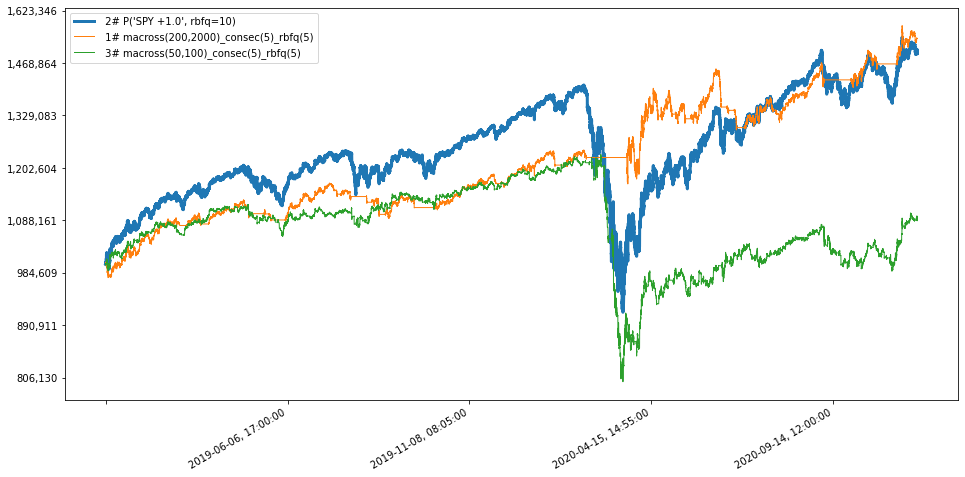

In [7]:
rslt0.plot()

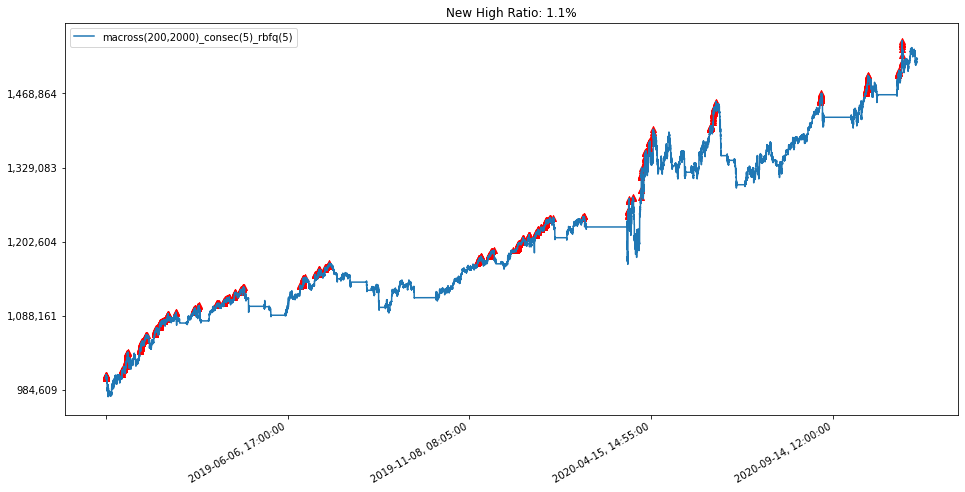

In [8]:
rslt0.plot_new_high(1)